In [1]:
import os
import sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), '..'))
if path_to_add not in sys.path:
    sys.path.append(path_to_add)

import time

from efficientnet.tfkeras import EfficientNetB4
from transformers import ViTImageProcessor, ViTForImageClassification, ViTFeatureExtractor, DetrForSegmentation, DetrFeatureExtractor
import torch
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

from Utilities.utilities import *
from Utilities.lime_segmentation import *


/home/pknab/miniconda3/envs/envi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    
    "XAI_algorithm": {
        "DSEG" : True,
        "LIME" : True,
        "SLIME" : True,
        "BayesLime" : True,
        "GLIME" : True,
    },

    'computation':{
        'num_workers': 3,
        'gpu_device': False,
        'gpu_num': "4",
    },
    
        
    'model_to_explain':{
        'EfficientNet' : True,
        'ResNet': False,
        'VisionTransformer': False,
    },
    
    'lime_segmentation':{
        #Lime Parameters
        'num_samples': 256,
        'num_features': 1000,
        'min_weight': 0.01,
        'top_labels': 2,
        'hide_color': None,
        'batch_size': 10,
        'verbose': True,
        
        'slic': True,
        'quickshift': False,
        'felzenszwalb': False,
        'watershed': False,
        
        'all_dseg': True,
        'DETR' : False,
        'SAM' : True,
        'points_per_side' : 32,
        'min_size': 512,
        
        'fit_segmentation' : True,        
        'slic_compactness' : 16,
        'num_segments': 20,
        'markers' : 16,
        'kernel_size' : 6,
        'max_dist' : 32,
        
        #Lime Segmentation Parameters
        'iterations': 1,
        'shuffle': False,
        'max_segments': 8,
        'min_segments': 1,
        'auto_segment': False, 
        
        # LIME Explanation Parameters
        "num_features_explanation": 2,
        "adaptive_num_features": False,
        "adaptive_fraction": True,
        
        'hide_rest': True,
        'positive_only': True,
        
    },
    
    "evaluation": {
        'noisy_background': True,
        
        #Correctness
        "model_randomization" : True,
        "explanation_randomization" : True,
        
        "single_deletion": True,
        "fraction" : 0.1,
        "fraction_std" : 0.05,
        
        "incremental_deletion": True,
        "incremental_deletion_fraction": 0.15,
        
        "stability": True,
        "repetitions": 8,
        
        #Output Completeness
        "preservation_check": True,
        "deletion_check": True,
        
        #Consistency
        "variation_stability": True,
        
        #Contrastivity
        "target_discrimination": True,
        
        #Compactness
        "size": True,
    }
}


from Utilities.utilities import *
from Utilities.lime_utilities import *
from Utilities.lime_segmentation import *
from Utilities.lime_base import *
from Utilities.GLIME import *

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = config['computation']['gpu_num'] if config['computation']['gpu_device'] else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if config['computation']['gpu_device'] else ''

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if config['computation']['gpu_device'] else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if config['computation']['gpu_device'] else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

if config['model_to_explain']['EfficientNet']: 
    model_explain = EfficientNetB4(weights='imagenet')
    model_explain_processor = None 
elif config['model_to_explain']['ResNet']:
    model_explain = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
    model_explain.eval()
    model_explain_processor = None
elif config['model_to_explain']['VisionTransformer']:
    model_explain_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-384')
    model_explain = ViTForImageClassification.from_pretrained('google/vit-base-patch32-384')

if config['lime_segmentation']['DETR']:
    feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")
    model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

else:
    sam_checkpoint = "../Models/pretrained/sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    if config['computation'].get('gpu_device'):
        model.to(device="cuda:0")
    else:
        model.to(device="cpu")

    feature_extractor = SamAutomaticMaskGenerator(model,
                                            min_mask_region_area=config['lime_segmentation']['min_size'],
                                            points_per_side=config['lime_segmentation']['points_per_side'],
                                            )
   
    

2024-03-06 14:24:55.759581: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


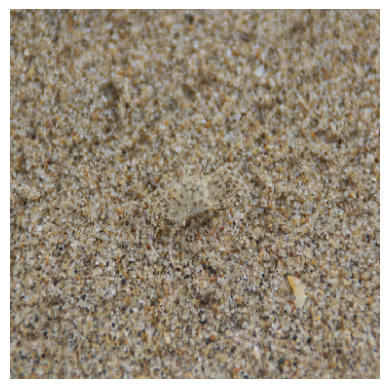

[[('n01753488', 'horned_viper', 0.20005487), ('n01986214', 'hermit_crab', 0.17209621), ('n01756291', 'sidewinder', 0.1536384), ('n02219486', 'ant', 0.0500162), ('n01665541', 'leatherback_turtle', 0.047487773)]]


[[('n01753488', 'horned_viper', 0.20005487),
  ('n01986214', 'hermit_crab', 0.17209621),
  ('n01756291', 'sidewinder', 0.1536384),
  ('n02219486', 'ant', 0.0500162),
  ('n01665541', 'leatherback_turtle', 0.047487773)]]

In [4]:
path_image_id = "../Dataset/Camouflage_crab.jpeg"
predict_image(path_image_id, model_explain, config, True, model_processor = model_explain_processor)

(-0.5, 379.5, 379.5, -0.5)

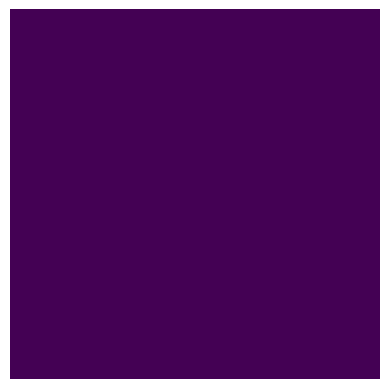

In [5]:
data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
if config["model_to_explain"]["EfficientNet"]:
    dim = (data.shape[0], data.shape[1])
elif config["model_to_explain"]["ResNet"]:
    dim = (data.shape[1], data.shape[2])
else:
    dim = (data['pixel_values'][0].shape[1], data['pixel_values'][0].shape[2])

plt.imshow(segment_seed(data, path_image_id, config, feature_extractor, model, dim))
plt.axis('off')

In [6]:
explainer = LimeImageExplainerDynamicExperimentation()
config['lime_segmentation']['num_segments'] = 16
data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)

if config['lime_segmentation']['all_dseg']:
    explanation = explainer.explain_instance(data, 
                                        model_explain,
                                        feature_extractor,
                                        model,
                                        config = config,
                                        shuffle = config['lime_segmentation']['shuffle'],
                                        image_path = path_image_id, 
                                        top_labels=config['lime_segmentation']['top_labels'], 
                                        hide_color=config['lime_segmentation']['hide_color'], 
                                        num_samples=config['lime_segmentation']['num_samples'],
                                        iterations= config['lime_segmentation']['iterations'],
                                        labels = (2,),
                                        segmentation_fn_seed = segment_seed_dynamic,
                                        segmentation_fn_dynamic = segment_image_dynamic,
                                        random_seed = 42)
else:
    explanation = explainer.explain_instance(data, 
                                        model_explain,
                                        None,
                                        None,
                                        config = config,
                                        segmentation_fn=lime_segmentation,
                                        top_labels=config['lime_segmentation']['top_labels'], 
                                        hide_color=config['lime_segmentation']['hide_color'], 
                                        num_samples=config['lime_segmentation']['num_samples'],
                                        random_seed = 42)



100%|██████████| 256/256 [00:19<00:00, 13.22it/s]


(-0.5, 379.5, 379.5, -0.5)

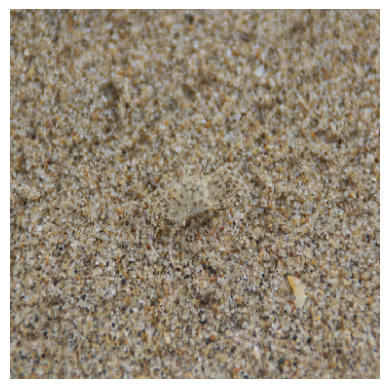

In [7]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], 
                                            positive_only=config['lime_segmentation']['positive_only'], 
                                            num_features=1, 
                                            hide_rest=config['lime_segmentation']['hide_rest'])

black = np.array([0, 0, 0], dtype=np.uint8)
gray = np.array([230,230,230], dtype=np.uint8)

#data = data.resize((mask.shape[0],mask.shape[1]))
# Create a mask to detect all black pixels
if config['model_to_explain']['EfficientNet']:
    changed = data_raw*mask[:,:,np.newaxis]
elif config['model_to_explain']['ResNet']:
    data_raw = data_raw.resize((mask.shape[0],mask.shape[1]))
    changed = data_raw*mask[:,:,np.newaxis]
elif config['model_to_explain']['VisionTransformer']:
    data_raw = data_raw.resize((mask.shape[0],mask.shape[1]))
    changed = data_raw*mask[:,:,np.newaxis]
changed = changed.astype(np.uint8)
for i in range(changed.shape[0]):
    for j in range(changed.shape[1]):
        if (changed[i,j] == black).all():
            changed[i,j] = gray


plt.imshow(changed)
plt.axis('off')  # Hide the axis on the image plot


(-0.5, 379.5, 379.5, -0.5)

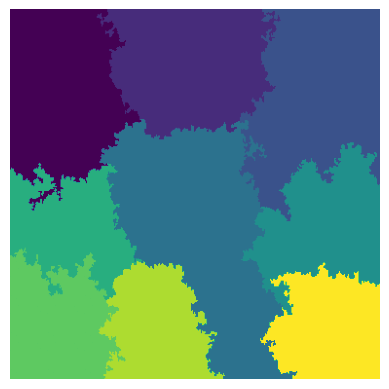

In [8]:
config['lime_segmentation']['num_segments'] = 16


data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)
if config["model_to_explain"]["EfficientNet"]:
    data_transformed_lime = data.copy()
elif config["model_to_explain"]["ResNet"]:
    data_transformed_lime = data.clone().detach().numpy()
    data_transformed_lime = data_transformed_lime.transpose(1,2,0)
else:
    data_transformed_lime= data.copy()
    data_transformed_lime = np.array(data_transformed_lime['pixel_values'][0])
    data_transformed_lime = data_transformed_lime.transpose(1,2,0)
            
lime_segments = lime_segmentation(data_transformed_lime, config)
plt.imshow(lime_segments)
plt.axis('off')

In [9]:
explainer = LimeImageExplainerDynamicExperimentation()
data, data_raw = load_and_preprocess_image(path_image_id, config, plot = False, model = model_explain_processor)

explanation = explainer.explain_instance(data, 
                                        model_explain,
                                        None,
                                        None,
                                        config = config,
                                        segmentation_fn=lime_segmentation,
                                        top_labels=config['lime_segmentation']['top_labels'], 
                                        hide_color=config['lime_segmentation']['hide_color'], 
                                        num_samples=config['lime_segmentation']['num_samples'],
                                        random_seed = 42)


  4%|▍         | 10/256 [00:00<00:18, 13.62it/s]

100%|██████████| 256/256 [00:18<00:00, 14.17it/s]


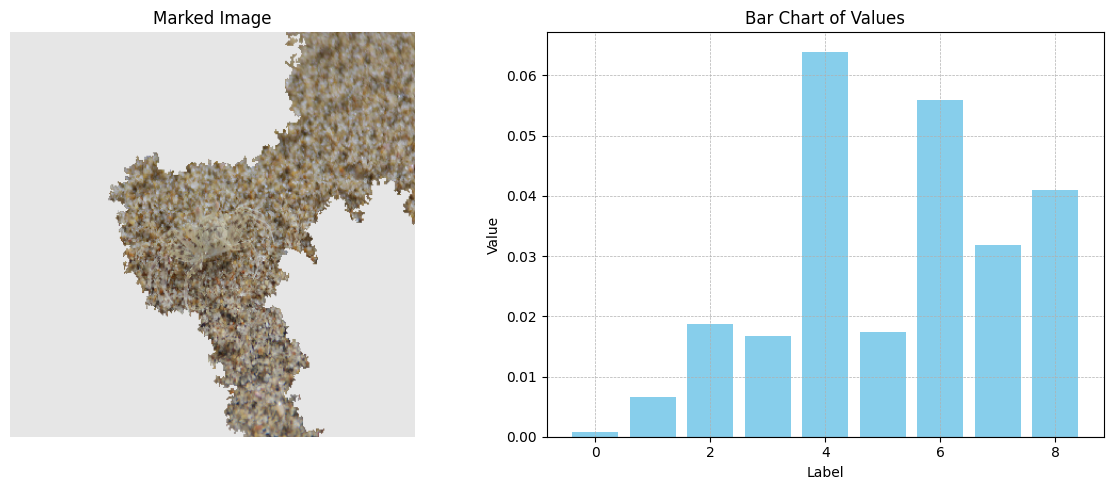

In [12]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], 
                                            positive_only=config['lime_segmentation']['positive_only'], 
                                            num_features=2, 
                                            hide_rest=config['lime_segmentation']['hide_rest'])

black = np.array([0, 0, 0], dtype=np.uint8)
gray = np.array([230,230,230], dtype=np.uint8)

#data = data.resize((mask.shape[0],mask.shape[1]))
# Create a mask to detect all black pixels
if config['model_to_explain']['EfficientNet']:
    changed = data_raw*mask[:,:,np.newaxis]
elif config['model_to_explain']['ResNet']:
    data_raw = data_raw.resize((mask.shape[0],mask.shape[1]))
    changed = data_raw*mask[:,:,np.newaxis]
elif config['model_to_explain']['VisionTransformer']:
    data_raw = data_raw.resize((mask.shape[0],mask.shape[1]))
    changed = data_raw*mask[:,:,np.newaxis]
changed = changed.astype(np.uint8)
for i in range(changed.shape[0]):
    for j in range(changed.shape[1]):
        if (changed[i,j] == black).all():
            changed[i,j] = gray

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns


# The first subplot for the marked image
ax[0].imshow(changed)
ax[0].axis('off')  # Hide the axis on the image plot
ax[0].set_title('Marked Image')

# Extract labels and values for the bar chart
labels, values, _ = zip(*explanation.local_exp[explanation.top_labels[0]])

# The second subplot for the bar chart
ax[1].bar(labels, values, color='skyblue')

# Add a title and labels to the axes for the bar chart
ax[1].set_title('Bar Chart of Values')
ax[1].set_xlabel('Label')
ax[1].set_ylabel('Value')

# Show grid lines for better readability on the bar chart
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Handle negative and positive values in y-axis on the bar chart
ax[1].axhline(0, color='grey', linewidth=0.8)

# Adjust the layout so that both subplots fit well in the figure
plt.tight_layout()

# Display the plots
plt.show()